# Setup:

In [ ]:
from google.colab import drive
from torchvision.datasets import CIFAR10
import torch
import os
import torchvision
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
downloaded = os.path.isdir("cifar-10-batches-py")
train = CIFAR10(root=".", download=not downloaded, train=True)
test = CIFAR10(root=".", train=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 63158982.84it/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
X_train = torch.tensor(train.data, dtype = torch.float32).permute(0, 3, 1, 2).div_(255).cuda()
y_train = torch.tensor(train.targets, dtype=torch.int64).cuda()
X_val = torch.tensor(test.data, dtype = torch.float32).permute(0, 3, 1, 2).div_(255).cuda()
y_val = torch.tensor(test.targets, dtype=torch.int64).cuda()

#Helper Function

In [ ]:
  # Register a forward hook to save the output of the activation layer
  def forward_hook_fn(m, i, o):
      m.out = o

  # Register a backward hook to save the gradients of the activation layer
  def backward_hook_fn(m, grad_input, grad_output):
      m.grad_out = grad_output[0]
      m.grad_in = grad_input[0]

# Sanity Check

frog


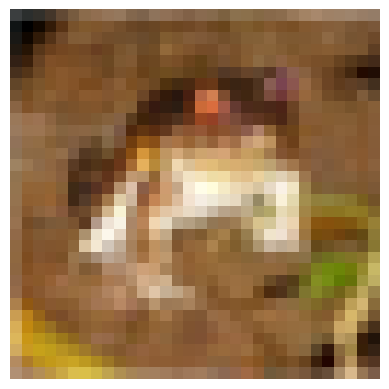

In [ ]:
classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]
sample = X_train[0].to("cpu")
print(classes[y_train[0].to("cpu")])
img = sample.mul(255).clamp_(0, 255).permute(1, 2, 0)
ndarr = img.to(dtype = torch.uint8)
plt.imshow(ndarr)
plt.axis("off")
plt.show()

In [ ]:
def create_layer(input, output, batch, activate_func, pooling):
  layer = nn.Sequential(nn.Conv2d(input, output, kernel_size=3, stride=1, padding=1))
  if batch == "Batch Normalization":
    layer.add_module("BN", nn.BatchNorm2d(output))
  elif batch == "Layer Normalization":
    layer.add_module("Layer Normalization", nn.InstanceNorm2d(output))
  else:
    pass
  if activate_func == "ReLU":
    layer.add_module("ReLU", nn.ReLU())
  elif activate_func == "Swish":
    layer.add_module("Swish", nn.SiLU())
  else:
    layer.add_module("Tanh", nn.Tanh())



  for module in layer.modules():
      if isinstance(module, nn.ReLU) or isinstance(module, nn.SiLU) or isinstance(module, nn.Tanh):
          module.register_forward_hook(forward_hook_fn)
          module.register_backward_hook(backward_hook_fn)

  if pooling:
    layer.add_module("pool", nn.MaxPool2d(kernel_size = 2, stride = 2))
  return layer

# Model:

In [ ]:
# VGG16 model
class VGG16(nn.Module):
    def __init__(self, num_classes=10, batch = "none", activate_func = "relu"):

        super(VGG16, self).__init__()
        self.layer1 = create_layer(3, 64, batch, activate_func, False)

        self.layer2 = create_layer(64, 64, batch, activate_func, True)

        self.layer3 = create_layer(64, 128, batch, activate_func, False)

        self.layer4 = create_layer(128, 128, batch, activate_func, True)

        self.layer5 = create_layer(128, 256, batch, activate_func, False)

        self.layer6 = create_layer(256, 256, batch, activate_func, False)

        self.layer7 = create_layer(256, 256, batch, activate_func, True)

        self.layer8 = create_layer(256, 512, batch, activate_func, False)

        self.layer9 = create_layer(512, 512, batch, activate_func, False)

        self.layer10 = create_layer(512, 512, batch, activate_func, True)

        self.layer11 = create_layer(512, 512, batch, activate_func, False)

        self.layer12 = create_layer(512, 512, batch, activate_func, False)

        self.layer13 = create_layer(512, 512, batch, activate_func, True)

        self.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(512, 512))
        if activate_func == "ReLU":
          self.fc.add_module("ReLU", nn.ReLU())
        elif activate_func == "Swish":
          self.fc.add_module("Swish", nn.SiLU())
        else:
          self.fc.add_module("Tanh", nn.Tanh())

        for module in self.fc.modules():
          if isinstance(module, nn.ReLU) or isinstance(module, nn.SiLU) or isinstance(module, nn.Tanh):
              module.register_forward_hook(forward_hook_fn)
              module.register_backward_hook(backward_hook_fn)

        self.fc1 = nn.Sequential(nn.Dropout(0.5), nn.Linear(512, 512))

        if activate_func == "ReLU":
          self.fc1.add_module("ReLU", nn.ReLU())
        elif activate_func == "Swish":
          self.fc1.add_module("Swish", nn.SiLU())
        else:
          self.fc1.add_module("Tanh", nn.Tanh())

        for module in self.fc1.modules():
          if isinstance(module, nn.ReLU) or isinstance(module, nn.SiLU) or isinstance(module, nn.Tanh):
              module.register_forward_hook(forward_hook_fn)
              module.register_backward_hook(backward_hook_fn)

        self.fc2= nn.Sequential(
            nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Training

In [ ]:
# Setting up Param

num_classes = 10
num_epochs = 10
learning_rate = 1e-3
batch_size = 100

#activation functions and normalizations:
norms = ["No Normalization", "Batch Normalization", "Layer Normalization"]
activate_funcs = ["ReLU", "Swish", "Tanh"]


# Loss and optimizer
loss_func = nn.CrossEntropyLoss()

In [ ]:
def get_accuracy(model, X, y, batch_size):
  correct = 0
  total = 0
  for i in range(0,X.size()[0], batch_size):
    indices = range(i, i + batch_size)
    X_batch, y_batch = X[indices], y[indices]
    outputs = model.forward(X_batch)
    outputs = torch.softmax(outputs, dim = 1)
    _, predicted = torch.max(outputs, dim = 1)
    total += y_batch.size()[0]
    correct += (predicted == y_batch).sum().item()
  return correct / total

In [ ]:
trials = []
for activate_func in activate_funcs:
  for norm in norms:
    print("Model with", activate_func, "and", norm)
    trial = {}
    trial["activation_function"] = activate_func
    trial["normalization"] = norm
    model = VGG16(num_classes, norm, activate_func).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

    #training model:
    loss_vals = []
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
      print("Epoch #", epoch + 1)
      perm = torch.randperm(X_train.size()[0])
      for i in range(0,X_train.size()[0], batch_size):
        optimizer.zero_grad()
        indices = perm[i : i + batch_size]
        X_batch, y_batch = X_train[indices], y_train[indices]
        outputs = model.forward(X_batch)
        loss = loss_func(outputs,y_batch)
        loss_vals.append(loss.item())
        loss.backward()
        optimizer.step()
      #Get training accuracy:
      acc = get_accuracy(model, X_train, y_train, batch_size)
      train_acc.append(acc)
      print("train accuracy:", acc)
      #Get validation accuracy:
      acc = get_accuracy(model, X_val, y_val, batch_size)
      val_acc.append(acc)
      print("validation accuracy:", acc)
    trial["loss"] = loss_vals
    trial["train_acc"] = train_acc
    trial["val_acc"] = val_acc
    trial["model"] = model
    trials.append(trial)


Model with ReLU and No Normalization
Epoch # 1
train accuracy: 0.0999
validation accuracy: 0.1011
Epoch # 2
train accuracy: 0.09852
validation accuracy: 0.102
Epoch # 3
train accuracy: 0.09878
validation accuracy: 0.1003
Epoch # 4
train accuracy: 0.10044
validation accuracy: 0.1015
Epoch # 5
train accuracy: 0.10074
validation accuracy: 0.0954
Epoch # 6
train accuracy: 0.10036
validation accuracy: 0.1007
Epoch # 7
train accuracy: 0.10136
validation accuracy: 0.0946
Epoch # 8
train accuracy: 0.10158
validation accuracy: 0.106
Epoch # 9
train accuracy: 0.10012
validation accuracy: 0.0974
Epoch # 10
train accuracy: 0.10106
validation accuracy: 0.102
Model with ReLU and Batch Normalization
Epoch # 1
train accuracy: 0.52832
validation accuracy: 0.5085
Epoch # 2
train accuracy: 0.69338
validation accuracy: 0.6511
Epoch # 3
train accuracy: 0.761
validation accuracy: 0.7093
Epoch # 4
train accuracy: 0.82216
validation accuracy: 0.7415
Epoch # 5
train accuracy: 0.8779
validation accuracy: 0.7699

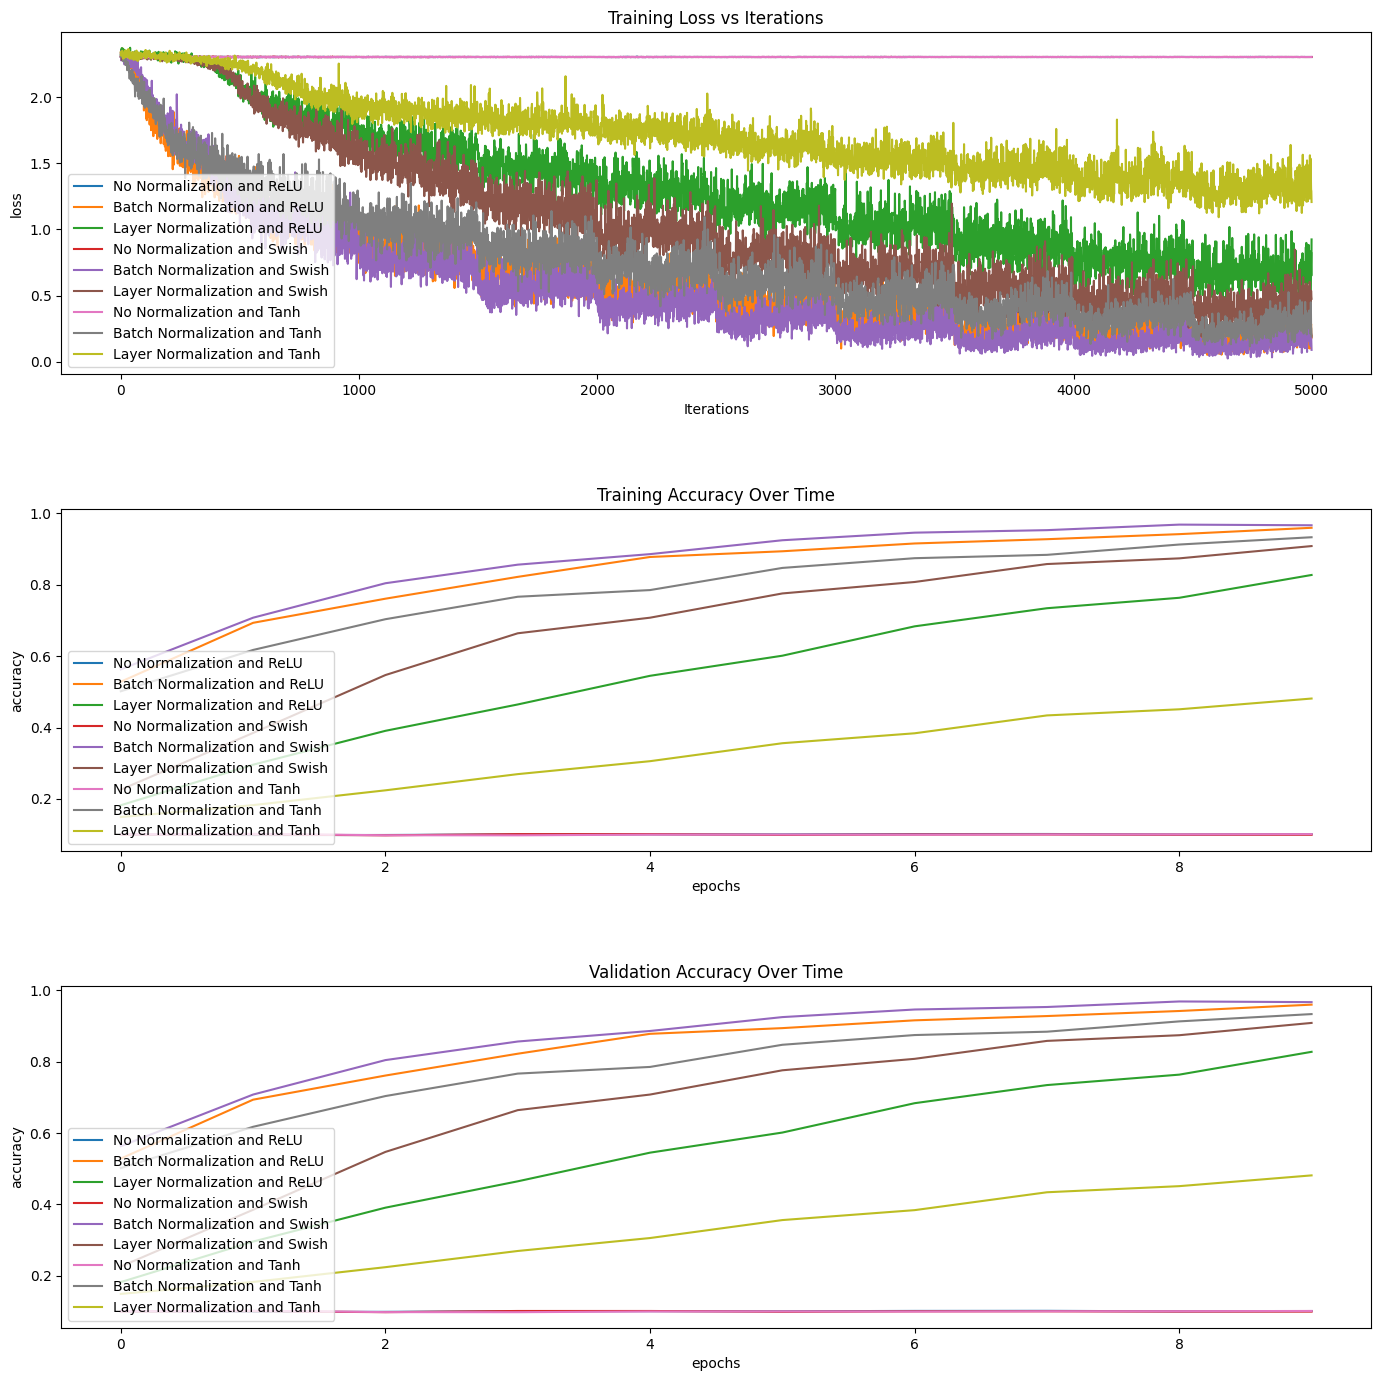

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

for trial in trials:
  #training loss vs iteration
  loss = trial["loss"]
  iterations = list(range(0, len(loss)))
  ax1.plot(iterations, loss, label=trial["normalization"] + " and " + trial["activation_function"])
  #training accuracy vs epoch
  train_acc = trial["train_acc"]
  epochs = list(range(0, len(train_acc)))
  ax2.plot(epochs, train_acc, label=trial["normalization"] + " and " + trial["activation_function"])
  #validation accuracy vs epoch
  val_acc = trial["train_acc"]
  epochs = list(range(0, len(val_acc)))
  ax3.plot(epochs, val_acc, label=trial["normalization"] + " and " + trial["activation_function"])

ax1.legend(loc='lower left')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Training Loss vs Iterations")
ax2.legend(loc='lower left')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Training Accuracy Over Time")
ax3.legend(loc='lower left')
ax3.set_xlabel("epochs")
ax3.set_ylabel("accuracy")
ax3.set_title("Validation Accuracy Over Time")

fig.tight_layout(pad=5.0)
fig.show()

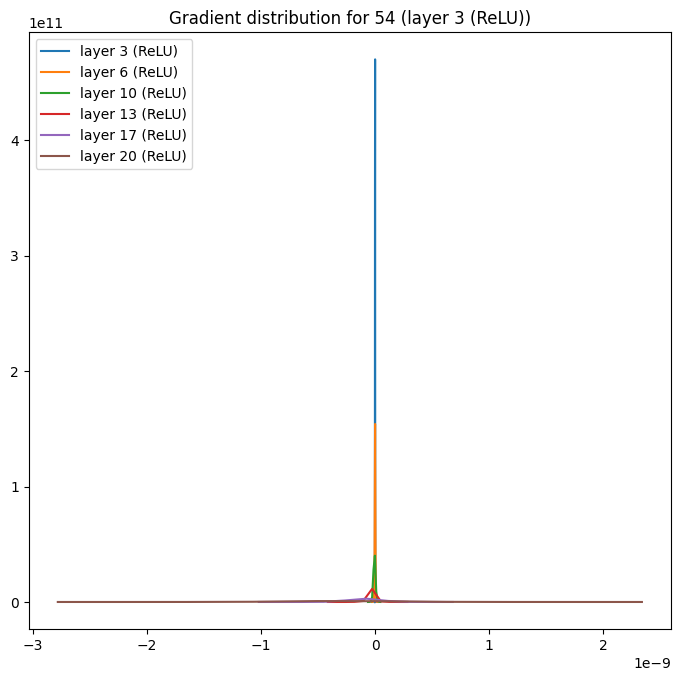

<Figure size 2000x400 with 0 Axes>

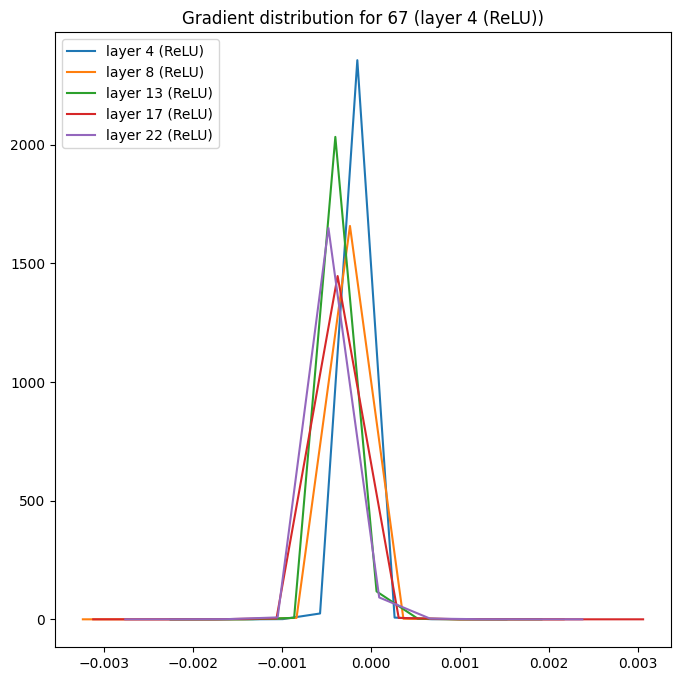

<Figure size 2000x400 with 0 Axes>

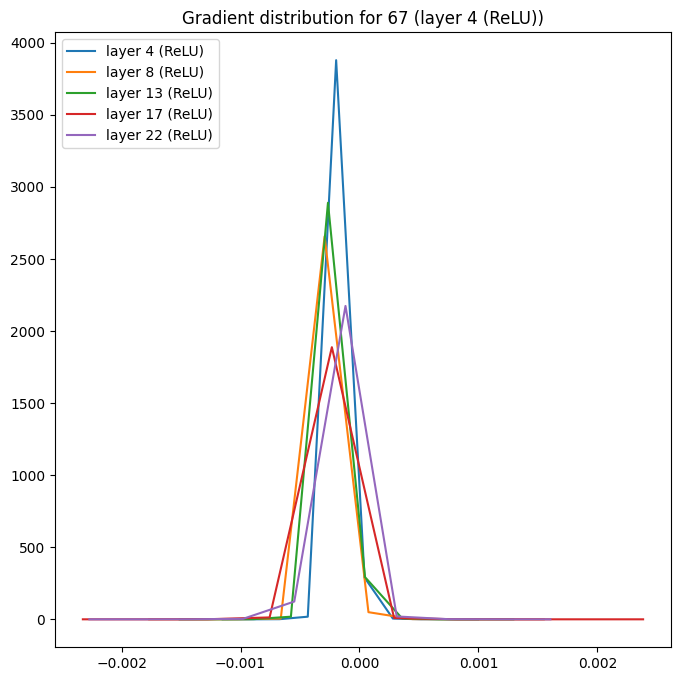

<Figure size 2000x400 with 0 Axes>

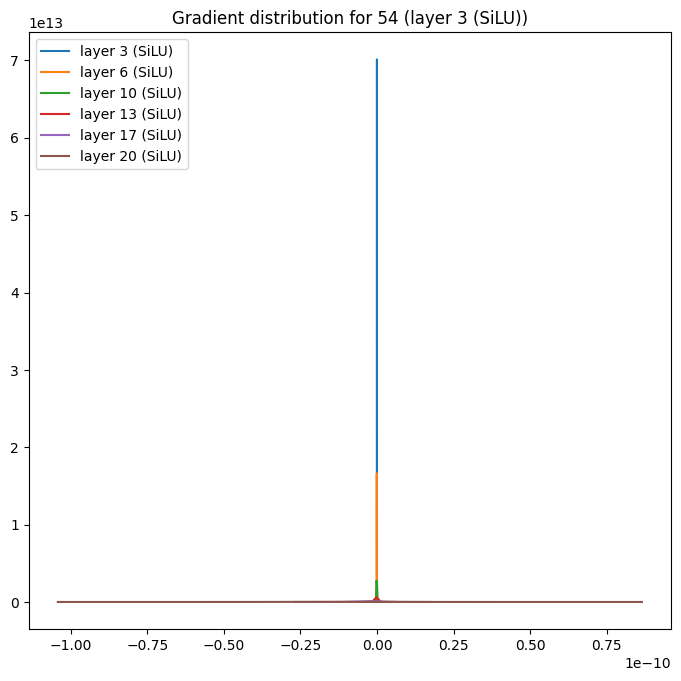

<Figure size 2000x400 with 0 Axes>

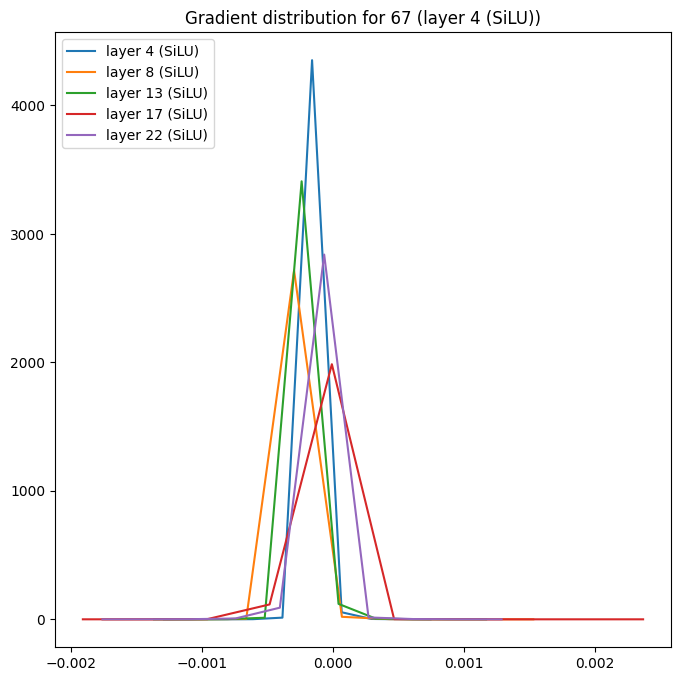

<Figure size 2000x400 with 0 Axes>

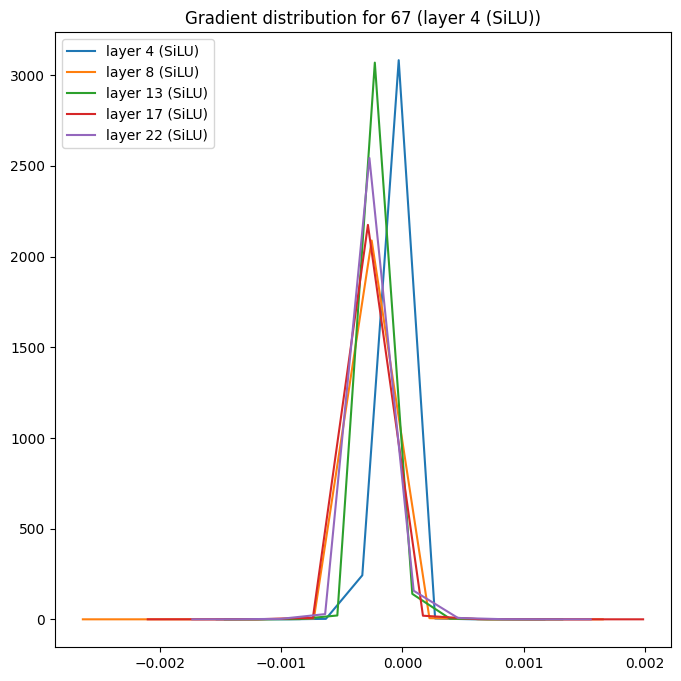

<Figure size 2000x400 with 0 Axes>

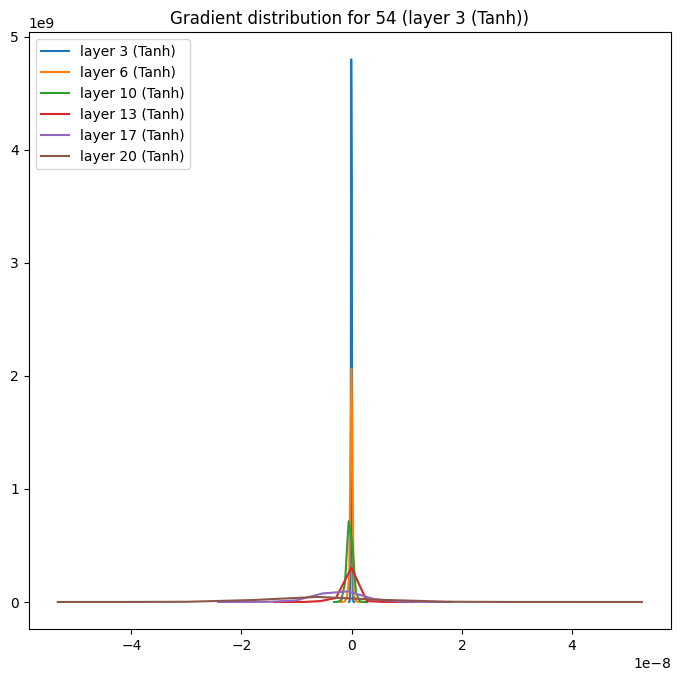

<Figure size 2000x400 with 0 Axes>

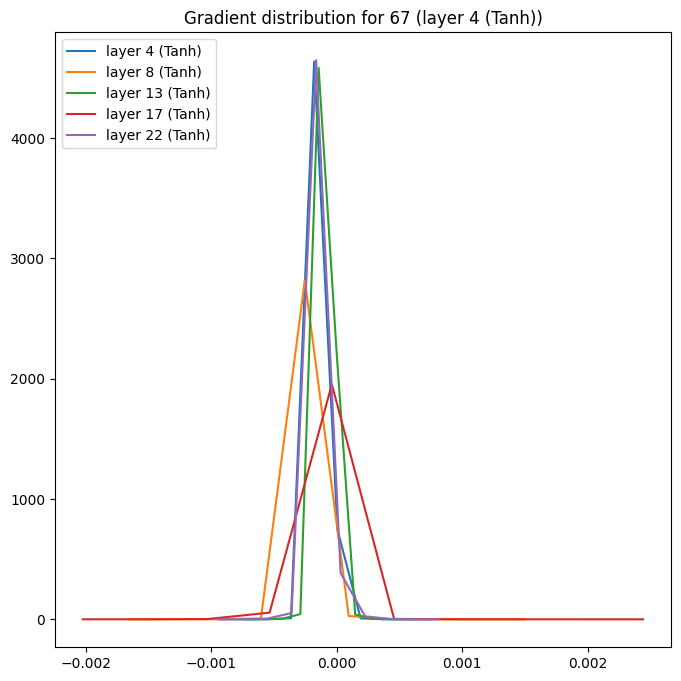

<Figure size 2000x400 with 0 Axes>

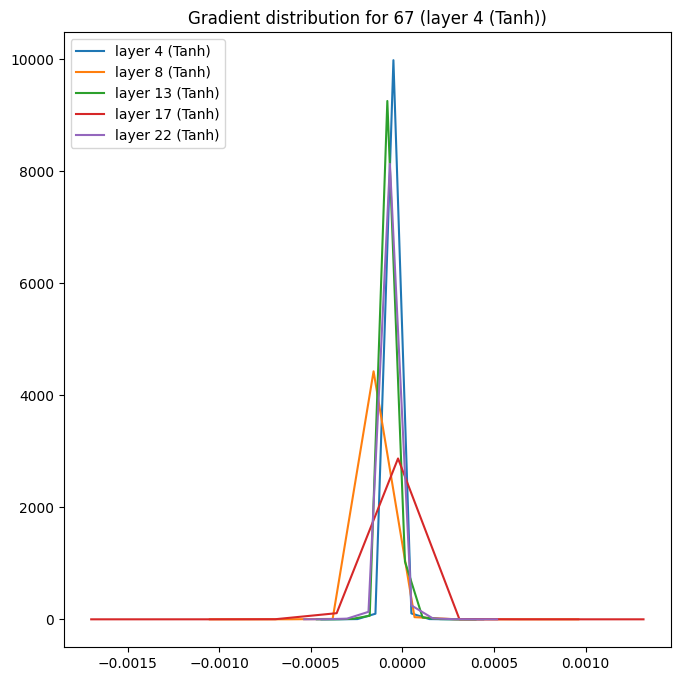

<Figure size 2000x400 with 0 Axes>

In [ ]:
for i in range(len(trials)):
  model = trials[i]["model"]
  fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

  plt.figure(figsize=(20, 4))
  legends = []


  for i, layer in enumerate(model.modules()):
      if 0 < i < 23:
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Tanh) or isinstance(layer, nn.SiLU):
            t = layer.grad_out
            hy, hx = np.histogram(t.cpu().detach().numpy(), bins=10, density=True) # use .cpu() and .detach().numpy() to move the tensor to CPU memory and convert it to a NumPy array
            ax1.plot(hx[:-1], hy)
            legends.append(f'layer {i} ({layer.__class__.__name__})')

  ax1.legend(legends,loc='upper left')
  ax1.set_title(f'Gradient distribution for {i} ({legends[0]})')
  fig.tight_layout(pad=5.0)
  fig.show()

In [ ]:
trials

[{'activation_function': 'ReLU',
  'normalization': 'No Normalization',
  'loss': [2.3034117221832275,
   2.302110195159912,
   2.300990104675293,
   2.3051857948303223,
   2.3031508922576904,
   2.3041768074035645,
   2.3062074184417725,
   2.303849697113037,
   2.305060625076294,
   2.302579164505005,
   2.298740863800049,
   2.3057920932769775,
   2.304049015045166,
   2.304609775543213,
   2.3033883571624756,
   2.3040130138397217,
   2.3005988597869873,
   2.302431106567383,
   2.3008980751037598,
   2.301839828491211,
   2.3051047325134277,
   2.306055784225464,
   2.3020365238189697,
   2.3047537803649902,
   2.3012030124664307,
   2.3035173416137695,
   2.3012325763702393,
   2.301466464996338,
   2.3034415245056152,
   2.300807476043701,
   2.3037891387939453,
   2.3035686016082764,
   2.3039968013763428,
   2.3048033714294434,
   2.3040082454681396,
   2.3046092987060547,
   2.302544593811035,
   2.3012449741363525,
   2.302178382873535,
   2.3033246994018555,
   2.3028588294

In [ ]:
import json
import torch
import pickle

for i in range(len(trials)):
  model_str = pickle.dumps(trials[i]['model'])

# update the dictionary with the string representation
  trials[i]['model'] = model_str.decode('latin1')

In [ ]:
with open('trials.json', 'r') as f:
    json.dump(trials, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Models without any normalization seem to not be learning, and I'm unsure why. However, it seems this is a reoccuring issue and has happened to other people(https://www.reddit.com/r/deeplearning/comments/j7f1c9/d_when_i_try_to_train_the_vgg16_model_without/). Not sure if this is worth pursuing, or just mentioning in the written report/presentation.

In [ ]:
print(trials[0]["loss"])

In [ ]:
import json

with open('trials.json', 'r') as f:
    trials = json.load(f)

skip
skip
skip
skip
skip
skip


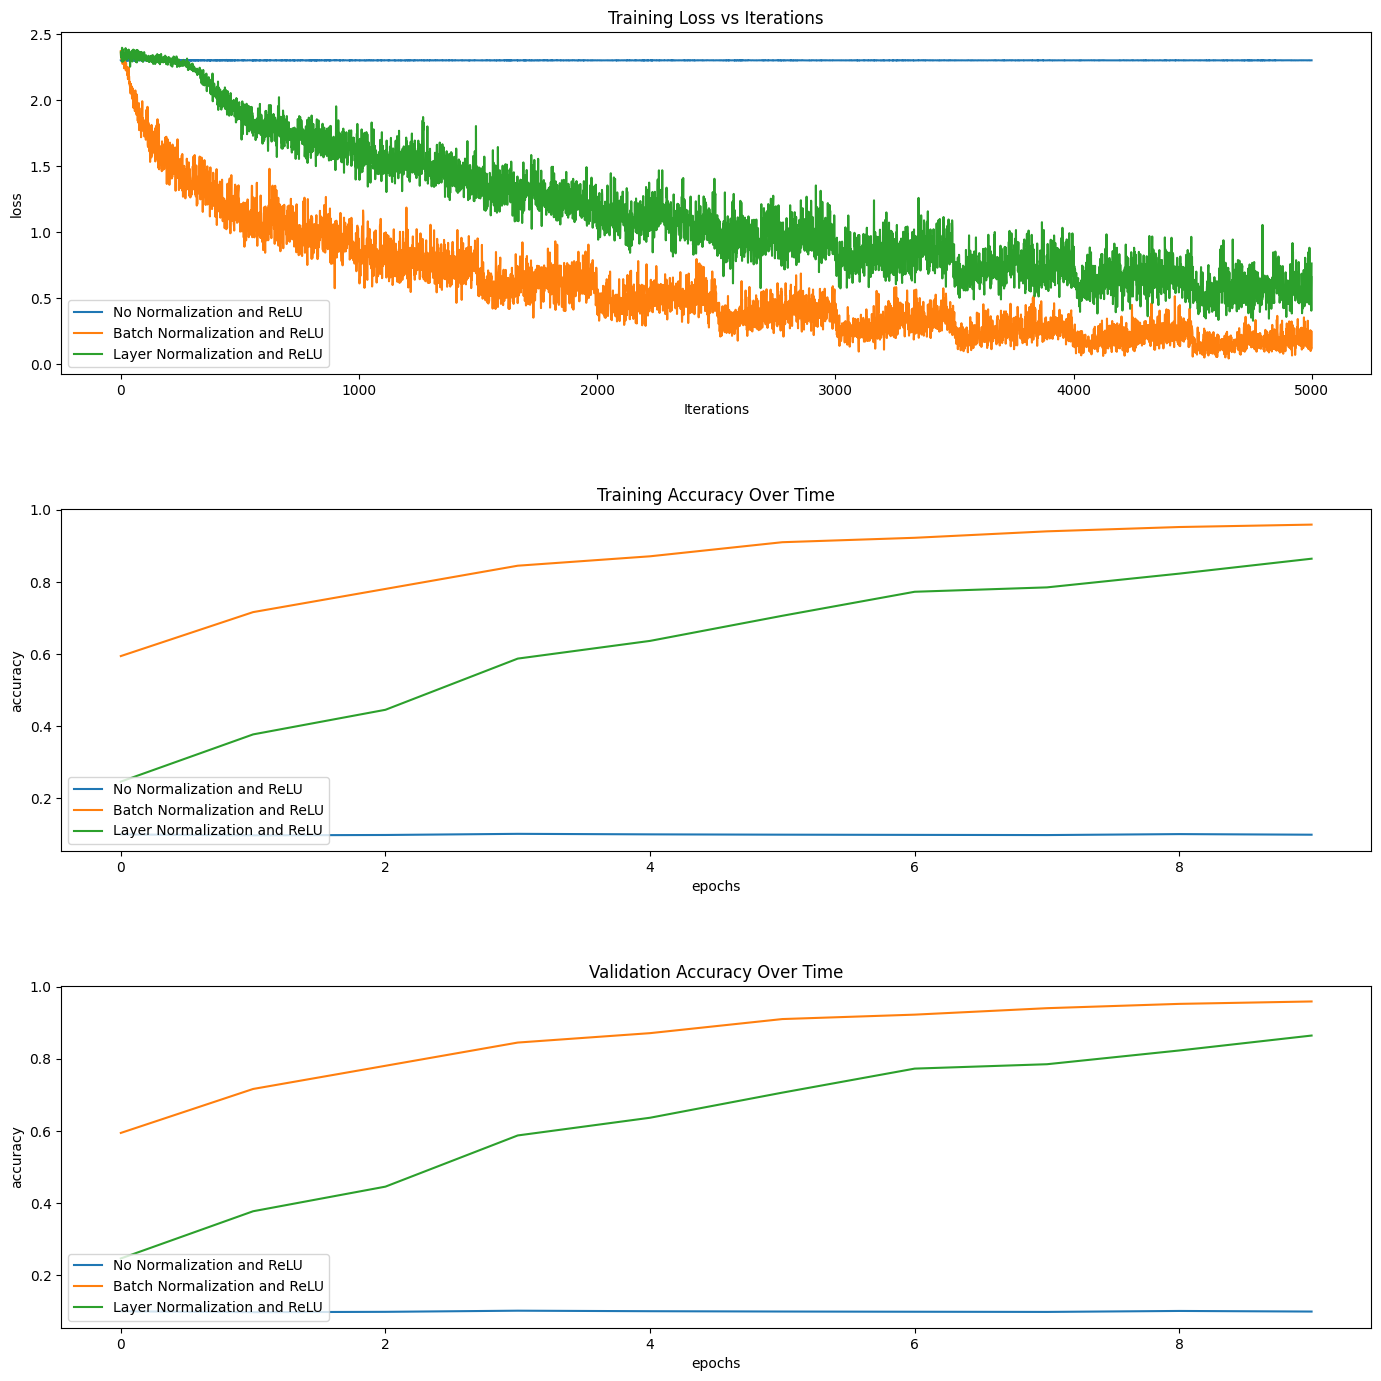

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

for trial in trials:
  #training loss vs iteration
  if trial["activation_function"] != "ReLU" :
    print("skip")
    continue
  loss = trial["loss"]
  iterations = list(range(0, len(loss)))
  ax1.plot(iterations, loss, label=trial["normalization"] + " and " + trial["activation_function"])
  #training accuracy vs epoch
  train_acc = trial["train_acc"]
  epochs = list(range(0, len(train_acc)))
  ax2.plot(epochs, train_acc, label=trial["normalization"] + " and " + trial["activation_function"])
  #validation accuracy vs epoch
  val_acc = trial["train_acc"]
  epochs = list(range(0, len(val_acc)))
  ax3.plot(epochs, val_acc, label=trial["normalization"] + " and " + trial["activation_function"])
ax1.legend(loc='lower left')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Training Loss vs Iterations")
ax2.legend(loc='lower left')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Training Accuracy Over Time")
ax3.legend(loc='lower left')
ax3.set_xlabel("epochs")
ax3.set_ylabel("accuracy")
ax3.set_title("Validation Accuracy Over Time")

fig.tight_layout(pad=5.0)
fig.show()